 32%|████████████████████████▉                                                     162/500 [ETA: 02:10, Elapsed: 01:02]


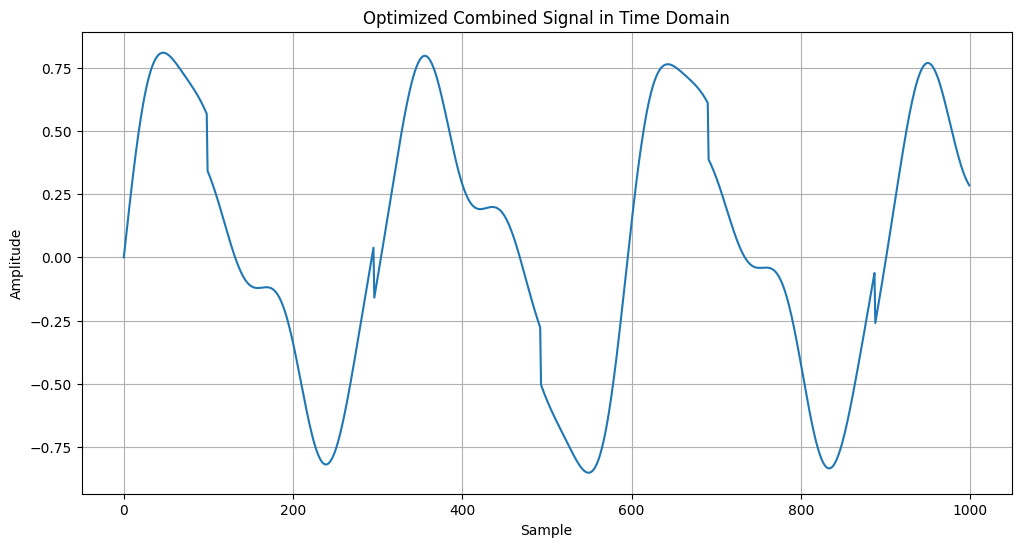

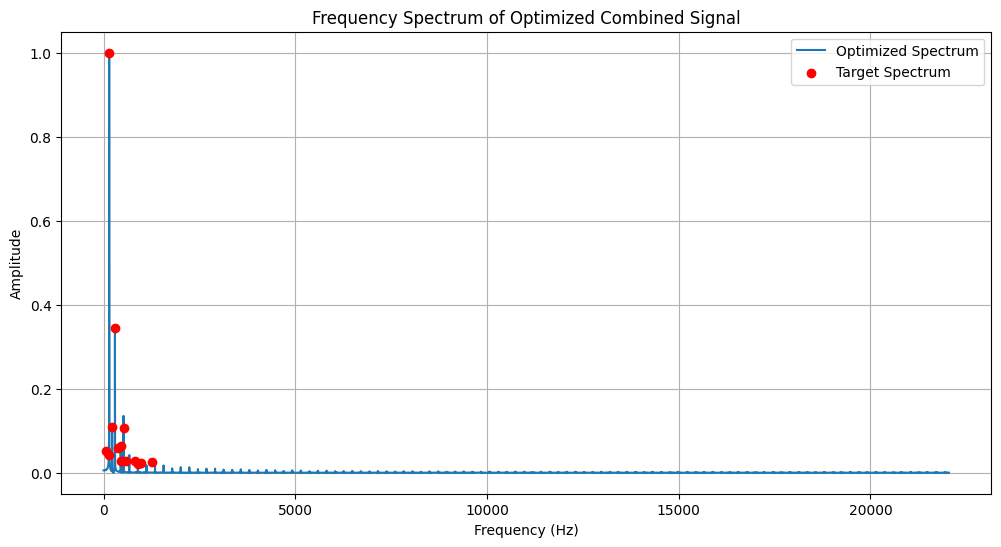

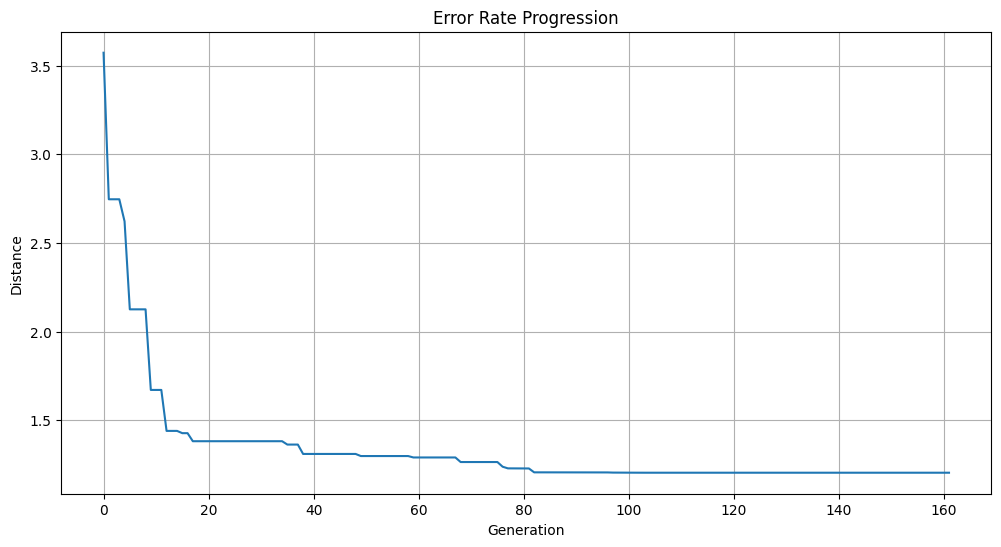

Optimal Frequencies: [198.66152442 297.05321111 523.77253987 179.32976352]
Optimal Amplitudes: [0.15194557 0.33213466 0.10248351 0.94804876]
Optimal Waveforms: ['sawtooth_wave', 'sine_wave', 'sine_wave', 'sine_wave']
[2024-06-12 23:25:21] 16-bit wave file with 44.1kHz sampling rate saved successfully to: C:\Users\egorp\Nextcloud\code\public_repos\audiospylt\experimental\rendered_audio\optimized_output_cellotest.wav


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, basinhopping, dual_annealing
from tqdm import tqdm
from IPython.display import Audio, display
from objective_functions import (
    itakura_saito_distance,
    cosine_similarity,
    spectral_convergence_distance,
    euclidean_distance,
    manhattan_distance,
    kullback_leibler_divergence,
    pearson_correlation_coefficient,
    mfcc_distance
)
from waveform_generators import sine_wave, square_wave, triangle_wave, sawtooth_wave, noise_wave
from generate_wave_file import generate_wave_file

# Check if the file exists
file_path = 'tsv/cello_single.tsv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File {file_path} does not exist.")

# Load TSV file into a DataFrame
df = pd.read_csv(file_path, sep='\t')

# Extract frequencies and amplitudes
frequencies = df['Frequency (Hz)'].values
amplitudes = df['Amplitude'].values

# Normalize amplitudes
amplitudes /= np.max(amplitudes)

# Parameters
duration = 1.0  # seconds
sample_rate = 44100  # samples per second

waveforms = [sine_wave, square_wave, triangle_wave, sawtooth_wave, noise_wave]

# Choose the objective function
objective = itakura_saito_distance

# Optimization constraints
max_oscillators = 4
bounds = [(50, 5000), (0, 1), (0, len(waveforms) - 1)] * max_oscillators

# Initialize tqdm progress bar and error history
n_generations = 500
pbar = tqdm(total=n_generations, unit=' iteration', bar_format='{l_bar}{bar} {n}/{total} [ETA: {remaining}, Elapsed: {elapsed}]')
error_history = []

# Callback function to update progress bar and error history
def callback(param, f):
    error = objective(param, frequencies, amplitudes, waveforms, duration, sample_rate)
    error_history.append(error)
    pbar.update(1)

# Define optimization functions
def run_differential_evolution():
    return differential_evolution(
        objective, bounds, args=(frequencies, amplitudes, waveforms, duration, sample_rate), 
        strategy='best1bin', maxiter=n_generations, popsize=10, tol=1e-6, 
        mutation=(0.5, 1), recombination=0.7, callback=callback
    )

def run_basinhopping():
    class MyBounds:
        def __init__(self, bounds):
            self.bounds = np.array(bounds)
        def __call__(self, **kwargs):
            x = kwargs["x_new"]
            tmax = np.all(x <= self.bounds[:, 1])
            tmin = np.all(x >= self.bounds[:, 0])
            return tmax and tmin

    mybounds = MyBounds(bounds)
    minimizer_kwargs = {
        'method': 'L-BFGS-B',
        'args': (frequencies, amplitudes, waveforms, duration, sample_rate),
        'bounds': bounds
    }
    
    def step_callback(x, f, accept):
        callback(x, f)
    
    initial_guess = np.array([np.random.uniform(low, high) for low, high in bounds])
    
    return basinhopping(
        objective, x0=initial_guess, niter=n_generations, accept_test=mybounds, 
        minimizer_kwargs=minimizer_kwargs, callback=step_callback
    )

def run_dual_annealing():
    return dual_annealing(
        objective, bounds, args=(frequencies, amplitudes, waveforms, duration, sample_rate), 
        maxiter=n_generations, callback=lambda x, f, context: callback(x, f)
    )

# Choose the optimization algorithm
optimization_algorithm = 'differential_evolution'

# Run the selected optimization algorithm
if optimization_algorithm == 'differential_evolution':
    result = run_differential_evolution()
elif optimization_algorithm == 'basinhopping':
    result = run_basinhopping()
elif optimization_algorithm == 'dual_annealing':
    result = run_dual_annealing()
else:
    raise ValueError(f"Unknown optimization algorithm: {optimization_algorithm}")

# Close progress bar
pbar.close()

# Extract optimal parameters
optimal_params = result.x

optimal_frequencies = optimal_params[0::3]
optimal_amplitudes = optimal_params[1::3]
optimal_waveform_indices = optimal_params[2::3].astype(int)

# Generate combined signal using optimal parameters
combined_signal = np.zeros(int(sample_rate * duration))
for freq, amp, waveform_index in zip(optimal_frequencies, optimal_amplitudes, optimal_waveform_indices):
    if np.isnan(waveform_index) or waveform_index < 0 or waveform_index >= len(waveforms):
        continue
    closest_freq_index = np.argmin(np.abs(frequencies - freq))
    matched_freq = frequencies[closest_freq_index]
    waveform = waveforms[waveform_index]
    combined_signal += waveform(matched_freq, amp, duration, sample_rate)

# Normalize combined signal
combined_signal /= np.max(np.abs(combined_signal))

# Compute FFT for plotting
fft_result = np.fft.fft(combined_signal)
fft_freqs = np.fft.fftfreq(len(fft_result), 1/sample_rate)

# Normalize the FFT result for comparison
fft_result_np = np.abs(fft_result)
fft_result_np /= np.max(fft_result_np)

# Plot results
def plot_results():
    # Time domain plot
    plt.figure(figsize=(12, 6))
    plt.plot(combined_signal[:1000])  # Plot the first 1000 samples
    plt.title('Optimized Combined Signal in Time Domain')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

    # Frequency domain plot
    plt.figure(figsize=(12, 6))
    plt.plot(fft_freqs[:len(fft_freqs)//2], fft_result_np[:len(fft_result_np)//2], label='Optimized Spectrum')
    plt.scatter(frequencies, amplitudes, color='red', label='Target Spectrum', zorder=5)
    plt.title('Frequency Spectrum of Optimized Combined Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot error history
    plt.figure(figsize=(12, 6))
    plt.plot(error_history)
    plt.title('Error Rate Progression')
    plt.xlabel('Generation')
    plt.ylabel('Distance')
    plt.grid(True)
    plt.show()

plot_results()

# Print optimal parameters
print("Optimal Frequencies:", optimal_frequencies)
print("Optimal Amplitudes:", optimal_amplitudes)
print("Optimal Waveforms:", [waveforms[i].__name__ for i in optimal_waveform_indices])

# Synthesize and save the audio using the provided script
output_filename = 'optimized_output_cellotest.wav'
generate_wave_file(combined_signal, sample_rate, custom_filename=output_filename, save_to_file=True)

output_path = os.path.join('rendered_audio', output_filename)
display(Audio(filename=output_path))


In [3]:
# Define the filename
tsv_filename = 'tsv/final_values_am.tsv'

# Create the DataFrame
final_values_df = pd.DataFrame({
    'Modulator': [1, 2, 3, 4],
    'Frequency (Hz)': optimal_frequencies[::-1],
    'Amplitude': optimal_amplitudes[::-1],
    'Waveform': [waveforms[i].__name__ for i in optimal_waveform_indices]
})

# Display the DataFrame
display(final_values_df)

# Save the DataFrame as a TSV file
final_values_df.to_csv(tsv_filename, sep='\t', index=False)

# Print the location where the TSV file was saved
print(f"TSV file was saved at: {os.path.abspath(tsv_filename)}")

,Modulator,Frequency (Hz),Amplitude,Waveform
0,1,179.329764,0.948049,sawtooth_wave
1,2,523.772540,0.102484,sine_wave
2,3,297.053211,0.332135,sine_wave
3,4,198.661524,0.151946,sine_wave


TSV file was saved at: C:\Users\egorp\Nextcloud\code\public_repos\audiospylt\experimental\tsv\final_values_am.tsv
